In [31]:
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from glob import glob
import os
import random
from sklearn.utils import shuffle
from patchify import patchify, unpatchify
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


# scaler = MinMaxScaler()
def preprocess_mask_categorical(train_masks):
    

    n, h, w,c = train_masks.shape
    train_masks_reshaped = train_masks.reshape(-1)
    
    predictions = labelencoder.transform(train_masks_reshaped)

    train_masks_input = predictions.reshape(n, h, w,c)
#     print("preprocess_mask_categorical",np.unique(train_masks_input))
    # Convert to one-hot encoding
    mask_categorical = to_categorical(train_masks_input, num_classes=11)
    return mask_categorical
 

def patchify_and_scale(samples, batch_size):
    while True:
        for image, mask in samples:
            # Preprocess image
            SIZE_X = (image.shape[1] // patch_size_image) * patch_size_image
            SIZE_Y = (image.shape[0] // patch_size_image) * patch_size_image
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)
            
            # Crop the mask
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
            mask = np.array(mask)
            


            # Extract patches
            patches_img = patchify(image, (patch_size_image, patch_size_image, 3), step=patch_size_image)
            patches_mask = patchify(mask, (patch_size_image, patch_size_image, 1), step=patch_size_image)

            # Initialize X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    # Patchify the image
                    single_patch_img = patches_img[i, j, :, :]
                    single_patch_img = (single_patch_img.astype('float32')) / 255. 
                    # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                    single_patch_img = single_patch_img[0]

                    # Patchify the mask
                    single_patch_mask = patches_mask[i, j, :, :]
                    single_patch_mask = single_patch_mask[0]

                    X_train.append(single_patch_img)
                    y_train.append(single_patch_mask)

                    if batch_size == len(X_train):
                        X_train = np.array(X_train)
                        y_train = np.array(y_train)
#                         print("patchify_and_scale",np.unique(y_train))
                        y_train_p =preprocess_mask_categorical(y_train)
#                         print(np.unique(y_train_p))
                        yield X_train, y_train_p
                        X_train = []
                        y_train = []


In [4]:
# Set patch size and batch size
patch_size_image = 256
batch_size = 7

# Specify the path
path = "D:/cources/Internship/2023/ASDC AI & Data analysis internship/dataset/semantic segmentation/"

# Load image and mask paths
image_paths = glob(os.path.join(path, "*.jpg"))
mask_paths = glob(os.path.join(path, "*.jpg___fuse.png"))

# Load images and masks
train_images = [cv2.imread(img_path, 1) for img_path in image_paths]
mask_images = [cv2.imread(mask_path, 0) for mask_path in mask_paths]

labelencoder = LabelEncoder()
train_masks=np.array(mask_images)
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_input = train_masks_reshaped_encoded.reshape(n, h, w)
print("train_masks_reshaped_encoded",np.unique(train_masks_reshaped_encoded))

# Save label encoder classes for later decoding
np.save('label_encoder_classes.npy', labelencoder.classes_)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_images, mask_images, test_size=0.3, random_state=0)


train_masks_reshaped_encoded [ 0  1  2  3  4  5  6  7  8  9 10]


In [5]:
# Create train and test datasets
train_samples = list(zip(X_train, y_train))
test_samples = list(zip(X_test, y_test))

train_dataset = patchify_and_scale(train_samples,batch_size)
test_dataset = patchify_and_scale(test_samples,batch_size)

Dataset shape: (7, 256, 256, 3)
Sample Image shape: (7, 256, 256, 11)


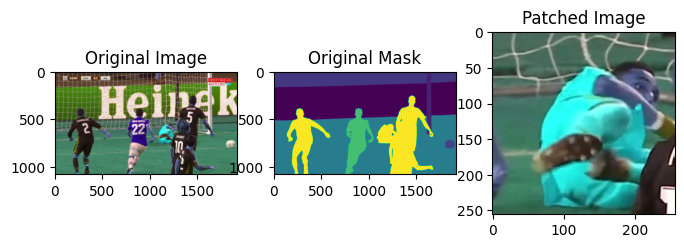

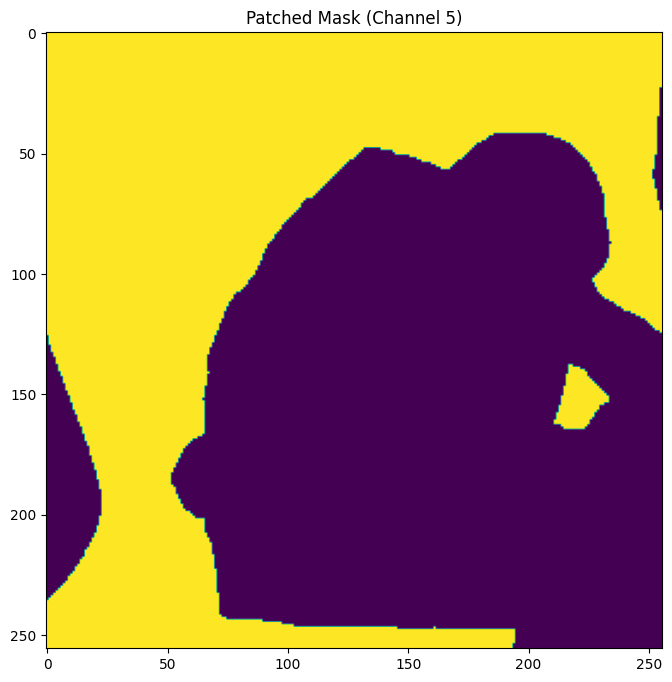

In [6]:
# Get one batch from the generator
example_generator = patchify_and_scale(train_samples,batch_size)
X_batch, y_batch = next(example_generator)
X_batch, y_batch = next(example_generator)
X_batch, y_batch = next(example_generator)


print("Dataset shape:",X_batch.shape)
print("Sample Image shape:", y_batch.shape)

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.imshow(X_train[0])
plt.title("Original Image")

# Display the original mask
plt.subplot(1, 3, 2)
plt.imshow(y_train[0])
plt.title("Original Mask")

# Display one patch from the batched image
plt.subplot(1, 3, 3)
plt.imshow(X_batch[4])
plt.title("Patched Image")

plt.show()

# Display one patch from the batched mask
plt.figure(figsize=(8, 8))
plt.imshow(y_batch[4, :, :, 5])
plt.title("Patched Mask (Channel 5)")
plt.show()

In [7]:
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=11, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

In [9]:

IMG_HEIGHT = X_batch.shape[1]
IMG_WIDTH  = X_batch.shape[2]
IMG_CHANNELS = X_batch.shape[3]
print(X_batch.shape)

(7, 256, 256, 3)


In [20]:
model= multi_unet_model(n_classes=11,
                        IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH,
                        IMG_CHANNELS=IMG_CHANNELS)

In [21]:
import segmentation_models as sm
weights = [0.09090,0.09090,0.09090,0.09090,0.09090,0.09090,0.09090,0.09090,0.09090,0.09090,0.09090]
class_weights = np.array([7.22785568e+03, 5.64636394e-01, 6.20626148e+00, 3.41854412e-01,
                          8.00363237e+01, 2.38080616e-01, 1.57039287e+01, 1.14647648e+00,
                          2.72831350e+01, 1.21979858e+00, 7.28160007e+00])


dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [22]:
metrics=['accuracy', jacard_coef]
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_jacard_coef',  # Metric to monitor (can be 'val_accuracy', 'val_jaccard_coef', etc.)
    patience=20,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [13]:
num_train_samples = len(X_train) * 28 
num_test_samples = len(X_test) * 28
print(num_train_samples, num_test_samples)

1960 840


In [23]:
model.load_weights('FOOTBALL_SEMANTIC_SEGMENTATION.hdf5') 

In [52]:
history=model.fit(train_dataset,steps_per_epoch=num_train_samples // batch_size, epochs=30,validation_data=test_dataset,
                  validation_steps=num_test_samples // batch_size )#,callbacks=[early_stopping]


Epoch 1/30
280/280 [==============================] - 289s 1s/step - loss: 0.2211 - accuracy: 0.9304 - jacard_coef: 0.8262 - val_loss: 0.2520 - val_accuracy: 0.9291 - val_jacard_coef: 0.7799
Epoch 2/30
280/280 [==============================] - 316s 1s/step - loss: 0.2222 - accuracy: 0.9304 - jacard_coef: 0.8224 - val_loss: 0.1991 - val_accuracy: 0.9390 - val_jacard_coef: 0.8458
Epoch 3/30
280/280 [==============================] - 229s 818ms/step - loss: 0.2164 - accuracy: 0.9322 - jacard_coef: 0.8298 - val_loss: 0.3284 - val_accuracy: 0.9075 - val_jacard_coef: 0.7504
Epoch 4/30
280/280 [==============================] - 179s 640ms/step - loss: 0.2212 - accuracy: 0.9315 - jacard_coef: 0.8243 - val_loss: 0.1953 - val_accuracy: 0.9400 - val_jacard_coef: 0.8486
Epoch 5/30
280/280 [==============================] - 183s 655ms/step - loss: 0.2014 - accuracy: 0.9359 - jacard_coef: 0.8364 - val_loss: 0.2169 - val_accuracy: 0.9331 - val_jacard_coef: 0.8234
Epoch 6/30
280/280 [================

In [55]:
# model.save('FOOTBALL_SEMANTIC_SEGMENTATION.hdf5') 

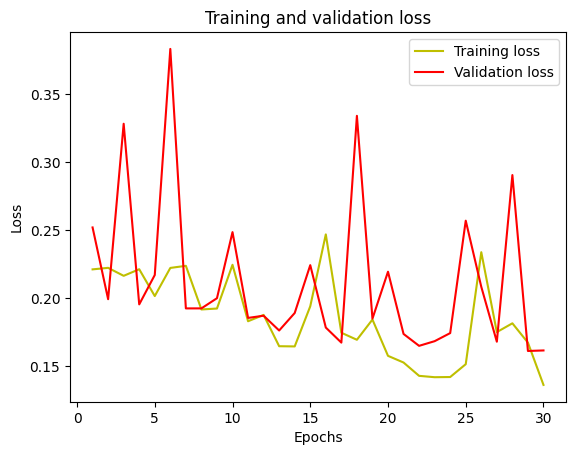

In [53]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


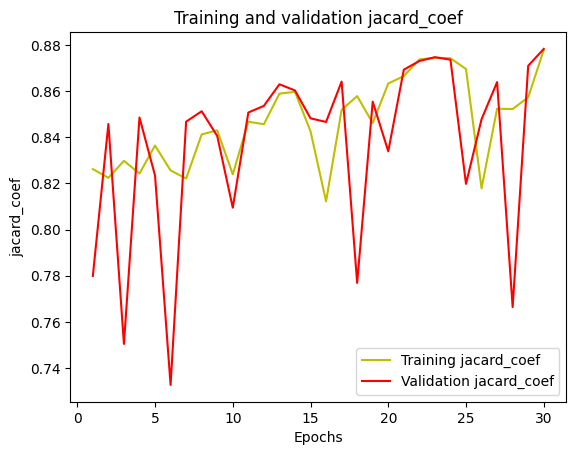

In [54]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training jacard_coef')
plt.plot(epochs, val_acc, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('jacard_coef')
plt.legend()
plt.show()

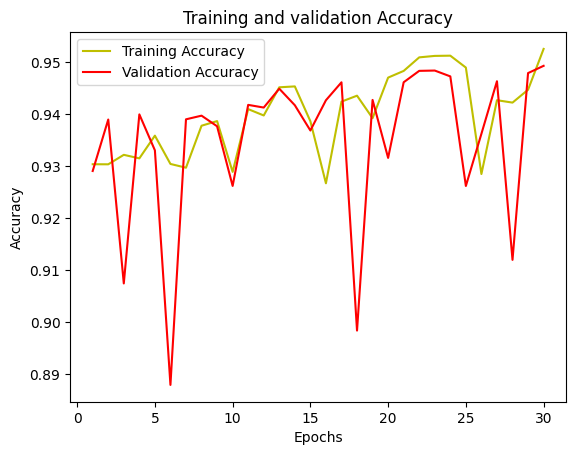

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
X_test[0].shape

1920

In [58]:

img=X_test[2]
SIZE_X = (img.shape[1]//patch_size_image)*patch_size_image #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size_image)*patch_size_image #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)     


patches_img = patchify(large_img, (patch_size_image, patch_size_image, 3), step=patch_size_image)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))
# plt.imshow(unpatched_prediction)
# plt.imshow(unpatched_prediction)
# plt.axis('off')




1/1 [==============================] - 0s 33ms/step


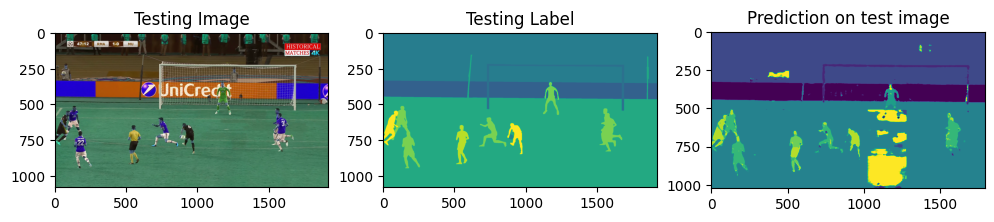

In [59]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(y_test[2])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(unpatched_prediction)
plt.show()